PHASE THREE

In [ ]:
#!pip install xgboost lightgbm catboost
#if you're not using a virtual environment

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    precision_score, 
    recall_score, 
    roc_auc_score, 
    classification_report, 
    confusion_matrix
)


from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier, 
    ExtraTreesClassifier, 
    AdaBoostClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Helper
from collections import Counter

print("All libraries imported successfully")

All libraries imported successfully!


1. Load the processed data arrays
2. Load the label encoder

In [ ]:
X_train_resampled = np.load('../data/processed/X_train_resampled.npy', allow_pickle=True).item()
y_train_resampled = np.load('../data/processed/y_train_resampled.npy', allow_pickle=True)
X_test_processed = np.load('../data/processed/X_test_processed.npy', allow_pickle=True).item()
y_test = np.load('../data/processed/y_test.npy', allow_pickle=True)
# Note: y_train and y_test don't need .item() because they were simple 1D arrays.


le = joblib.load('../models/label_encoder.joblib')
labels = le.classes_

print("Data loaded successfully.")
print(f"X_train_resampled shape: {X_train_resampled.shape}")
print(f"y_train_resampled shape: {y_train_resampled.shape}")
print(f"X_test_processed shape: {X_test_processed.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Target labels: {labels}")

Data loaded successfully.
X_train_resampled shape: (5301, 244)
y_train_resampled shape: (5301,)
X_test_processed shape: (885, 244)
y_test shape: (885,)
Target labels: ['Dropout' 'Enrolled' 'Graduate']


In [ ]:
# dictionary for the models being tested
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SGD Classifier": SGDClassifier(loss='log_loss', random_state=42), # 'log_loss' makes it predict probabilities
    "Support Vector Machine": SVC(probability=True, random_state=42), # probability=True is needed for ROC-AUC
    "Random Forest": RandomForestClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42) # verbose=0 stops it from printing training logs
}

print(f"{len(models)} Defined models.")

Defined 11 models.


 1. Train the model
 2. Get predictions on the TEST set
 3. Get probability predictions (for ROC and AUC)
 4. Calculate metrics
 5. ROC-AUC for multi-class
 6. Store results

In [ ]:
results_list = []

for name, model in models.items():
    print(f"--- Training {name} ---")
    start_time = time.time()
    

    model.fit(X_train_resampled, y_train_resampled)
    
    
    y_pred = model.predict(X_test_processed)
    
    
    y_proba = model.predict_proba(X_test_processed)
    
    
    train_time = time.time() - start_time
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    
    roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    
    
    results_list.append({
        "Model": name,
        "F1 (Weighted)": f1,
        "Accuracy": accuracy,
        "ROC-AUC (OVR)": roc_auc,
        "Precision (Weighted)": precision,
        "Recall (Weighted)": recall,
        "Train Time (s)": train_time
    })
    
    print(f"Finished {name} in {train_time:.2f}s.\n")

--- Training Logistic Regression ---
Finished Logistic Regression in 3.96s.

--- Training K-Nearest Neighbors ---
Finished K-Nearest Neighbors in 4.01s.

--- Training Decision Tree ---
Finished Decision Tree in 1.81s.

--- Training SGD Classifier ---
Finished SGD Classifier in 1.30s.

--- Training Support Vector Machine ---
Finished Support Vector Machine in 73.29s.

--- Training Random Forest ---
Finished Random Forest in 16.66s.

--- Training Extra Trees ---
Finished Extra Trees in 25.03s.

--- Training AdaBoost ---
Finished AdaBoost in 3.32s.

--- Training XGBoost ---


/home/spacetime/student-dropout-predictor/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [14:00:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Finished XGBoost in 41.71s.

--- Training LightGBM ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12340
[LightGBM] [Info] Number of data points in the train set: 5301, number of used features: 130
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/home/spacetime/student-dropout-predictor/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/spacetime/student-dropout-predictor/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Finished LightGBM in 4.51s.

--- Training CatBoost ---
Finished CatBoost in 78.50s.



1. Convert the list of results into a DataFrame
2. Sorting by the most important metric, F1 (Weighted)

In [ ]:
results_df = pd.DataFrame(results_list)

results_df = results_df.sort_values(by="F1 (Weighted)", ascending=False)

print("--- Model Comparison ---")
display(results_df)

--- Model Comparison ---


,Model,F1 (Weighted),Accuracy,ROC-AUC (OVR),Precision (Weighted),Recall (Weighted),Train Time (s)
5,Random Forest,0.758882,0.764972,0.885493,0.757344,0.764972,16.657164
9,LightGBM,0.750974,0.755932,0.881500,0.747947,0.755932,4.509542
10,CatBoost,0.750687,0.755932,0.883270,0.747506,0.755932,78.503062
8,XGBoost,0.748789,0.752542,0.882245,0.746602,0.752542,41.706650
4,Support Vector Machine,0.748710,0.743503,0.875864,0.757328,0.743503,73.292472
0,Logistic Regression,0.738964,0.726554,0.874421,0.761998,0.726554,3.957252
6,Extra Trees,0.732129,0.742373,0.864935,0.730906,0.742373,25.028393
3,SGD Classifier,0.731238,0.733333,0.852305,0.734382,0.733333,1.299638
7,AdaBoost,0.728304,0.715254,0.852605,0.753336,0.715254,3.316205
2,Decision Tree,0.665491,0.664407,0.711573,0.666909,0.664407,1.807656


1. Get the name of the best performing model
2. Get the already trained model from our dictionary
3. Get its predictions again (or store them from the loop)

--- In-Depth Analysis for Best Model: Random Forest ---

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.81      0.73      0.77       284
    Enrolled       0.52      0.45      0.48       159
    Graduate       0.81      0.90      0.85       442

    accuracy                           0.76       885
   macro avg       0.71      0.69      0.70       885
weighted avg       0.76      0.76      0.76       885


Confusion Matrix:


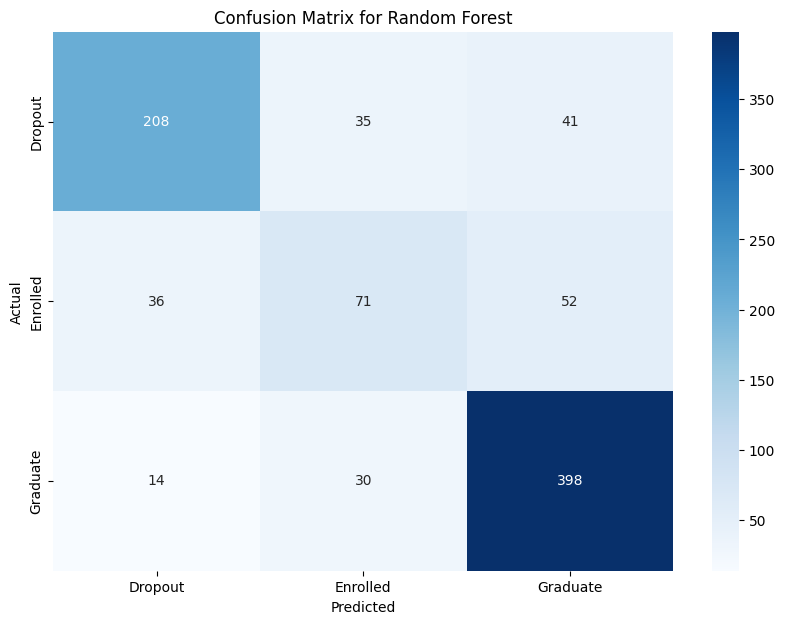

In [ ]:
best_model_name = results_df.iloc[0]['Model']
print(f"--- In-Depth Analysis for Best Model: {best_model_name} ---")


final_model = models[best_model_name]


y_pred_final = final_model.predict(X_test_processed)

# 1. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final, target_names=labels))

# 2. Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title(f'Confusion Matrix for {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Saving the best model to the 'models' folder
model_save_path = f"../models/best_model.joblib"
joblib.dump(final_model, model_save_path)

print(f"Best model ({best_model_name}) saved to {model_save_path}")

Best model (Random Forest) saved to ../models/best_model.joblib
